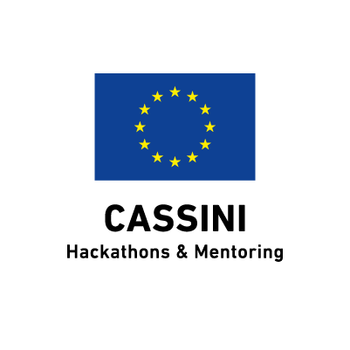

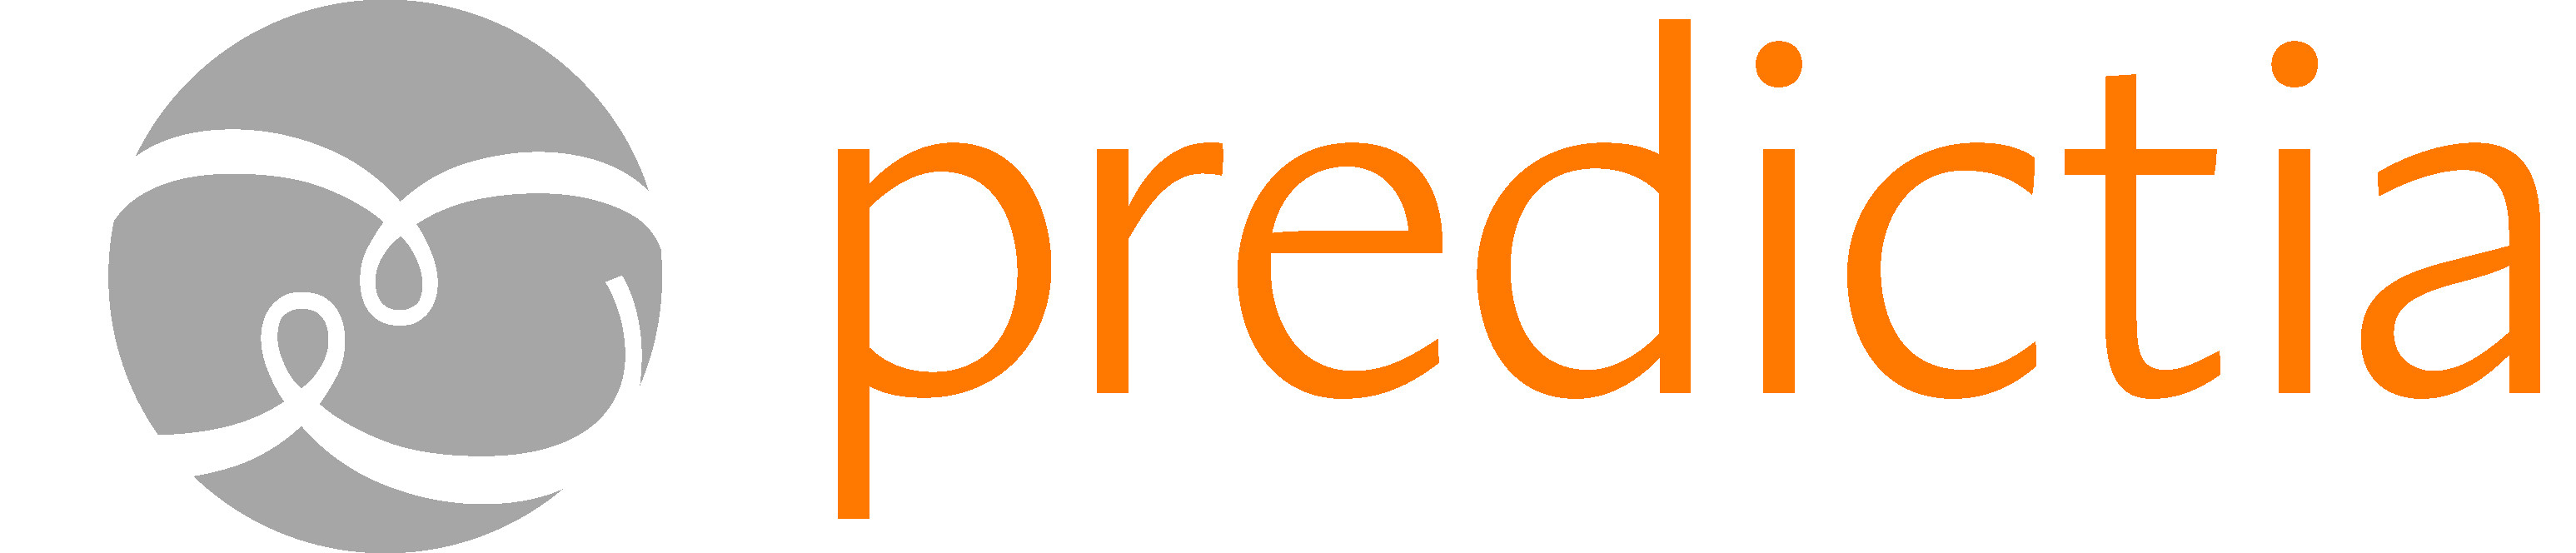

Importamos los paquetes necesarios:

In [1]:
import glob
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xskillscore as xs

import warnings
warnings.filterwarnings('ignore')

## Descargando los datos

Hemos almacenado los datos que vamos a utilizar en este notebook en nuestro Cloud para que todos podáis descargarlos y ejecutar este notebook.

Para que se tenga una idea de los datos que se han descargado y procesado mediante el uso de Wekeo:
- Para la concentración de hielo: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview
- Para la temperatura del aire a 2m de altura: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview

Ambos datasets se encuentran en proyecciones diferentes, con lo que ha sido necesario realizar una interpolación entre las rejillas. Esto no se ha hecho en el notebook para evitar hacerlo demasiado extenso.

Descargamos los datos:

In [2]:
!wget https://cloud.predictia.es/s/b53dPYnYFFqRG49/download

--2021-11-06 09:35:55--  https://cloud.predictia.es/s/b53dPYnYFFqRG49/download
Resolving cloud.predictia.es (cloud.predictia.es)... 51.15.110.102
Connecting to cloud.predictia.es (cloud.predictia.es)|51.15.110.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219991430 (210M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 209,80M  27,2MB/s    in 7,6s    

2021-11-06 09:36:05 (27,5 MB/s) - ‘download’ saved [219991430/219991430]



Cambiamos el nombre de los datos descargados y descomprimimos el fichero (.zip):

In [3]:
!mv download cassini-predictia.zip

In [4]:
!unzip cassini-predictia.zip

Archive:  cassini-predictia.zip
   creating: cassini-predictia-data/
  inflating: cassini-predictia-data/1980.nc  
  inflating: cassini-predictia-data/1981.nc  
  inflating: cassini-predictia-data/1982.nc  
  inflating: cassini-predictia-data/1983.nc  
  inflating: cassini-predictia-data/1984.nc  
  inflating: cassini-predictia-data/1985.nc  
  inflating: cassini-predictia-data/1986.nc  
  inflating: cassini-predictia-data/1987.nc  
  inflating: cassini-predictia-data/1988.nc  
  inflating: cassini-predictia-data/1989.nc  
  inflating: cassini-predictia-data/1990.nc  
  inflating: cassini-predictia-data/1991.nc  
  inflating: cassini-predictia-data/1992.nc  
  inflating: cassini-predictia-data/1993.nc  
  inflating: cassini-predictia-data/1994.nc  
  inflating: cassini-predictia-data/1995.nc  
  inflating: cassini-predictia-data/1996.nc  
  inflating: cassini-predictia-data/1997.nc  
  inflating: cassini-predictia-data/1998.nc  
  inflating: cassini-predictia-data/1999.nc  
  inflating

In [5]:
!rm cassini-predictia.zip

## Leyendo los datos

Para el análisis de datos multidimensionales (espacio y tiempo), el paquete por excelencia es Xarray.

In [6]:
files = glob.glob('cassini-predictia-data/*.nc')

In [7]:
files.sort()

Leemos los datos que hay disponibles desde 1980 hasta 2016 (sin incluirlo). Esto se hace fácilmente gracias a la función open_mfdataset() de Xarray, que permite leer datos multidimensionales concatenandolos por una de sus dimensiones. En principio, Xarray es lo suficientemente "listo" como para saber por qué dimensión debe concatenar. Es decir, en nuestro caso como "x" e "y" son idénticas en todos los datasets y la única dimensión que cambia entre ellos es el "time", Xarray entiende que tiene que concatenar por esta última.

In [8]:
data = xr.open_mfdataset(files[:-5])

In [9]:
data.load()

<xarray.Dataset>
Dimensions:  (y: 432, x: 432, time: 432)
Coordinates:
  * y        (y) float32 5.388e+06 5.362e+06 5.338e+06 ... -5.362e+06 -5.388e+06
  * x        (x) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2015-12-01
    lon      (y, x) float64 -135.0 -135.1 -135.3 -135.4 ... 44.73 44.87 45.0
    lat      (y, x) float64 16.62 16.82 17.02 17.22 ... 17.22 17.02 16.82 16.62
Data variables:
    siconca  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    tas      (time, y, x) float32 296.6 296.5 296.5 296.4 ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

## Transformando los datos

Aplicamos una serie de transformaciones a los datos para dejarlos en un formato más vistoso. En primer lugar, se eliminan unos outliers que se habían visto en la variable de temperatura (estos podrían haber aparecido a la hora de realizar la interpolación entre rejillas). En segundo lugar, transformamos las unidades de los datasets dejando a la temperatura en ºC y la concentracion de hielo en tanto por ciento (%). Por último, seleccionamos un área que está más centrada en el polo.

In [10]:
data['tas'] = data['tas'].where(data['tas'] != 0, drop=True)

In [11]:
data['tas'] = data['tas'] - 273.15
data['siconca'] = data['siconca'] * 100

In [12]:
data = data.isel(x=slice(100, 300), y=slice(50, 350))

## Mostrando las medias temporales

Con los datos una vez transformados, vamos a echarlos un vistazo! Para ello vamos a hacer unos pequeños mapas de la media temporal de las dos variables disponibles (tas y siconca).

In [13]:
tas_mean = data.tas.mean(dim='time')
siconca_mean = data.siconca.mean(dim='time')

In [14]:
def get_axes():
        projection = ccrs.NorthPolarStereo()
        ax = plt.axes(projection=projection)
        ax.coastlines(lw=1.5)
        return ax

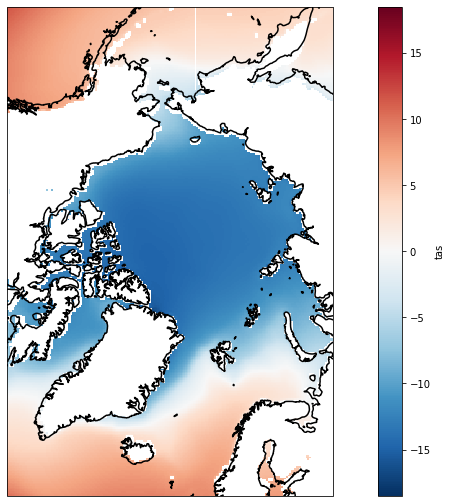

In [15]:
plt.figure(figsize=(16, 9))
ax = get_axes()
tas_mean.plot(ax=ax)

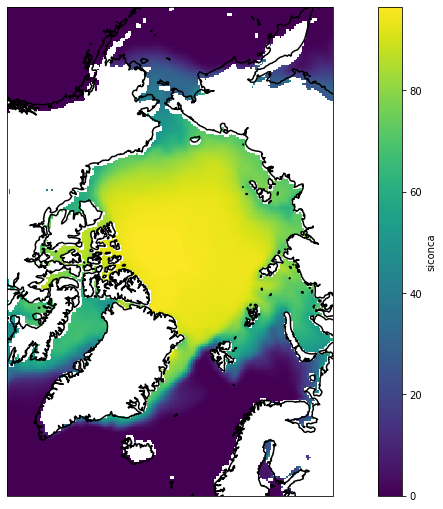

In [16]:
plt.figure(figsize=(16, 9))
ax = get_axes()
siconca_mean.plot(ax=ax)

## Mostrando la correlación temporal entre variables

Hemos planteado este notebook como un estudio de la relación temporal entre la cantidad de hielo del Ártico y la temperatura del aire del mismo. Por tanto, es necesario hacer el cómputo de la correlación ya que es una medida que sirve justo para esto.

Para ello, vamos a hacer la correlación anual con el objetivo de ver como ha afectado el aumento de temperatura media anual (conocido por los efectos del cambio climático) a la cantidad de hielo en el ártico.

In [17]:
correlation = xs.pearson_r(
    data.resample(time='YS').mean().siconca, data.resample(time='YS').mean().tas,
    dim='time',
)

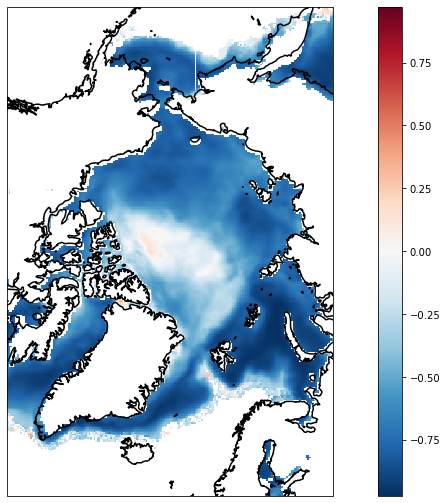

In [18]:
plt.figure(figsize=(16, 9))
ax = get_axes()
correlation.plot(ax=ax)

Como se ve en la figura anterior, la correlación es prácticamente < 0 en todo el Ártico. Esto indica que existe una relación inversa entre la temperatura y la cantidad de hielo, es decir, la cantidad de hielo disminuye a medida que aumenta la temperatura.

In [19]:
mean_corr = round(float(correlation.mean().values), 2)
max_corr = round(float(correlation.min().values), 2)
p90_corr = round(float(correlation.quantile(0.1).values), 2)

In [20]:
print(f"Media: {mean_corr}, Máximo: {max_corr}, Percentil 90: {p90_corr}")

Media: -0.62, Máximo: -0.97, Percentil 90: -0.88


Además se trada de una correlación alta de -0.62 en promedio en el Ártico, alcanzando valores pico de en torno a -0.9 (incluso llegando a un valor máximo de -0.97)

Text(0.5, 0, 'Temperature at 2 meters (ºC)')

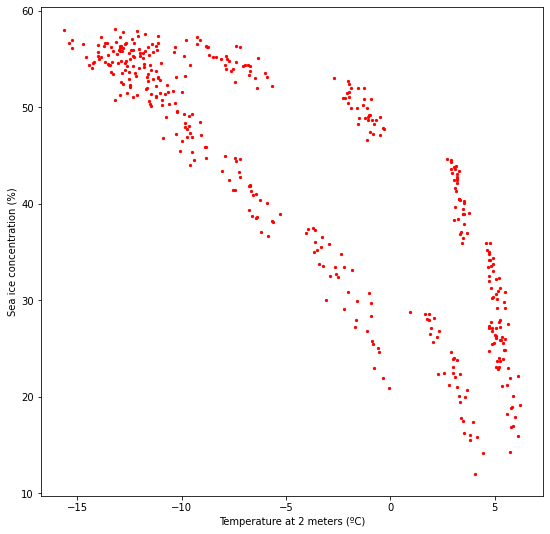

In [21]:
plt.figure(figsize=(9, 9))
xr.plot.scatter(data.mean('x').mean('y'), x='tas', y='siconca', s=5, color='r')
plt.ylabel('Sea ice concentration (%)')
plt.xlabel('Temperature at 2 meters (ºC)')

## Más formas de verlo!

A continuación vamos a ver una figura del número de celdas en el ártico con un valor superior al 50% de concentración de hielo para cada año desde 1980 hasta 2016. A su vez, vamos a representar en el mismo gráfico a la temperatura.

In [22]:
def data_over_siconca_threshold(data, threshold):
    over_siconca = data['siconca'].where(data['siconca'] >= threshold)
    over_siconca = over_siconca.where(np.isnan(over_siconca), other=1)
    over_siconca = over_siconca.where(
            np.isnan(data.siconca.isel(time=0))==False,
            drop=True
        )
    return over_siconca

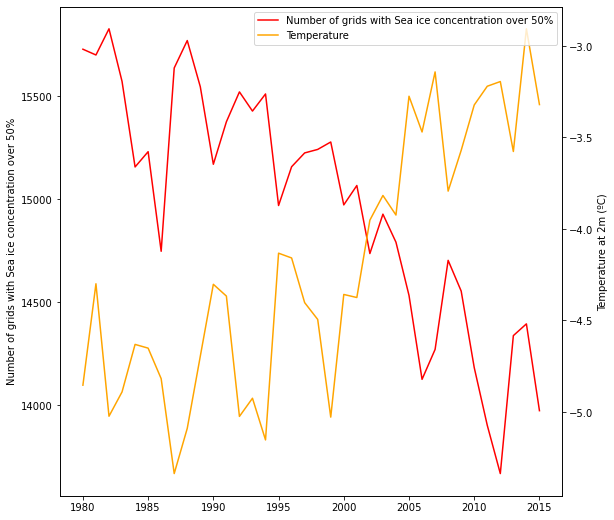

In [23]:
threshold = 50
over_siconca = data_over_siconca_threshold(data.resample(time='YS').mean(), threshold)
plt.figure(figsize=(9, 9))
ax1 = plt.subplot()
l1, = ax1.plot(range(1980, 2016), over_siconca.sum('x').sum('y'), color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(range(1980, 2016), data['tas'].resample(time='YS').mean().mean('x').mean('y'), color='orange')
ax1.set_ylabel(f'Number of grids with Sea ice concentration over {threshold}%')
ax2.set_ylabel('Temperature at 2m (ºC)')

plt.legend([l1, l2],
           [f'Number of grids with Sea ice concentration over {threshold}%', "Temperature"],
           loc='upper right')

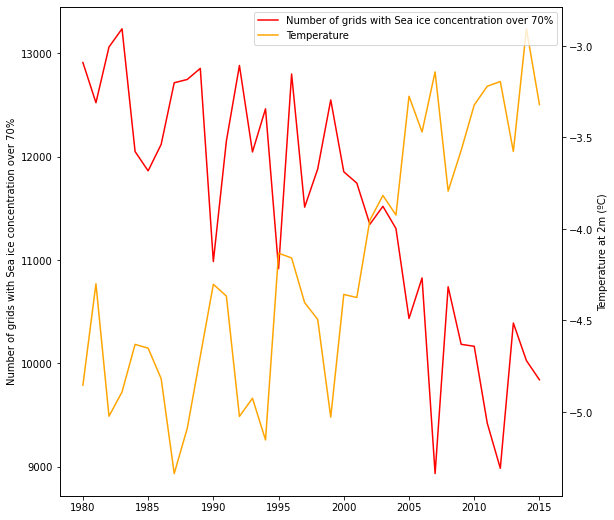

In [24]:
threshold = 70
over_siconca = data_over_siconca_threshold(data.resample(time='YS').mean(), threshold)
plt.figure(figsize=(9, 9))
ax1 = plt.subplot()
l1, = ax1.plot(range(1980, 2016), over_siconca.sum('x').sum('y'), color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(range(1980, 2016), data['tas'].resample(time='YS').mean().mean('x').mean('y'), color='orange')
ax1.set_ylabel(f'Number of grids with Sea ice concentration over {threshold}%')
ax2.set_ylabel('Temperature at 2m (ºC)')

plt.legend([l1, l2],
           [f'Number of grids with Sea ice concentration over {threshold}%', "Temperature"],
           loc='upper right')

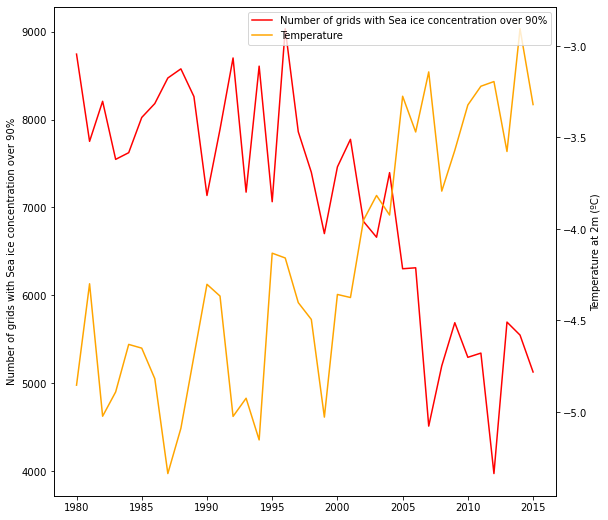

In [25]:
threshold = 90
over_siconca = data_over_siconca_threshold(data.resample(time='YS').mean(), threshold)
plt.figure(figsize=(9, 9))
ax1 = plt.subplot()
l1, = ax1.plot(range(1980, 2016), over_siconca.sum('x').sum('y'), color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(range(1980, 2016), data['tas'].resample(time='YS').mean().mean('x').mean('y'), color='orange')
ax1.set_ylabel(f'Number of grids with Sea ice concentration over {threshold}%')
ax2.set_ylabel('Temperature at 2m (ºC)')

plt.legend([l1, l2],
           [f'Number of grids with Sea ice concentration over {threshold}%', "Temperature"],
           loc='upper right')